# Kaggle RSNA Intracranial Hemorrhage Detection example

In [1]:
from functools import reduce
import os
import random

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from features import CNNFeatureExtractor

In [2]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
RANDOM_SEED = 2020
DEBUG_MODE = True

DATA_BASE_PATH = '/data/'
PNG_DIR = 'png_256/'
NUM_SUBJ_PER_SPLIT = 50

IMG_DIR = DATA_BASE_PATH + PNG_DIR + "train"
SAVE_DIR = DATA_BASE_PATH + "png_256_resnet50features/" + str(NUM_SUBJ_PER_SPLIT) + "_subj_per_split/"

### Define the paths to images

In [4]:
file_names = os.listdir(IMG_DIR)

In [5]:
all([f.endswith(".png") for f in file_names])

True

In [6]:
num_imgs = len(file_names)
print("There are a total of {} images available.".format(num_imgs))

There are a total of 752802 images available.


## Train/test split

We will use only a subset of images (less than half), which was pre-specified earlier prior to writing this notebook, such that different images of the same patient do not appear in the training as well as the test datasets.

In [11]:
train_splits_csv = 'train_splits_' + str(NUM_SUBJ_PER_SPLIT) + '.csv'
tmp_df = pd.read_csv(DATA_BASE_PATH + PNG_DIR + train_splits_csv)
train_split = list(tmp_df.filename.values)

In [12]:
test_splits_csv = 'test_splits_' + str(NUM_SUBJ_PER_SPLIT) + '.csv'
tmp_df = pd.read_csv(DATA_BASE_PATH + PNG_DIR + test_splits_csv)
test_split = list(tmp_df.filename.values)

In [13]:
lockbox_splits_csv = 'lockbox_splits_' + str(NUM_SUBJ_PER_SPLIT) + '.csv'
tmp_df = pd.read_csv(DATA_BASE_PATH + PNG_DIR + lockbox_splits_csv)
lockbox_split = list(tmp_df.filename.values)

In [14]:
print(len(train_split), len(test_split), len(lockbox_split))

198543 198381 355878


Here, the training and the test splits contain images (brain CT slices) for `100*NUM_SUBJ_PER_SPLIT` patients each.

### Extract features.

Initialize the feature extractor using the pre-trained ResNet50 model without the last fully connected layer:

In [15]:
feature_extractor = CNNFeatureExtractor(model="ResNet50")

102973440/102967424 [==============================] - 2s 0us/step: 


Get the test data features:

In [16]:
features_test, file_names_test = feature_extractor.get_features(
    img_dir=IMG_DIR, img_files=test_split, batch_size=64, verbose=1,
    workers=8, use_multiprocessing=True
)

3100/3100 [==============================] - 605s 195ms/step


In [17]:
print(features_test.shape)

(198381, 2048)


Get the training data features (notice that we do not need to re-initialize the feature extraction model):

In [18]:
features_train, file_names_train = feature_extractor.get_features(
    img_dir=IMG_DIR, img_files=train_split, batch_size=32, verbose=1, workers=8, use_multiprocessing=True
)

6205/6205 [==============================] - 631s 102ms/step


In [19]:
print(features_train.shape)

(198543, 2048)


Get the lockbox data features. It runs out of GPU memory if we do all images at once. So, we split the lockbox data into 10 parts for processing.

In [20]:
n_parts = 10
m = len(lockbox_split) // n_parts
features_lockbox = [None for _ in range(n_parts)]
file_names_lockbox = [None for _ in range(n_parts)]

for i in range(n_parts):
    if i == n_parts-1:
        s = lockbox_split[(i*m):]
    else:
        s = lockbox_split[(i*m):((i+1)*m)]
    features_lockbox[i], file_names_lockbox[i] = feature_extractor.get_features(
        img_dir=IMG_DIR, img_files=s, batch_size=32,
        verbose=1, workers=8, use_multiprocessing=True
    )

1113/1113 [==============================] - 110s 99ms/step


In [21]:
tmp = [features_lockbox[i].shape for i in range(n_parts)]
print(tmp)
print(np.sum([s[0] for s in tmp]))

[(35587, 2048), (35587, 2048), (35587, 2048), (35587, 2048), (35587, 2048), (35587, 2048), (35587, 2048), (35587, 2048), (35587, 2048), (35595, 2048)]
355878


In [22]:
features_lockbox = np.concatenate(features_lockbox, axis=0)
print(features_lockbox.shape)

(355878, 2048)


In [23]:
np.unique(features_lockbox, axis=0).shape

(351976, 2048)

In [24]:
np.unique(features_lockbox, axis=1).shape

(355878, 1970)

In [25]:
file_names_lockbox_backup = file_names_lockbox
file_names_lockbox = reduce(lambda x, y: x+y, file_names_lockbox)
print(len(file_names_lockbox))
print(np.unique(file_names_lockbox).shape)

355878
(355878,)


Save the resulting features:

In [27]:
print(SAVE_DIR)

with open(SAVE_DIR + "features_train.npy", "wb") as f:
    np.save(f, features_train)
    np.save(f, file_names_train)
    
with open(SAVE_DIR + "features_test.npy", "wb") as f:
    np.save(f, features_test)
    np.save(f, file_names_test)
    
with open(SAVE_DIR + "features_lockbox.npy", "wb") as f:
    np.save(f, features_lockbox)
    np.save(f, file_names_lockbox)

/data/png_256_resnet50features/50_subj_per_split/


Confirm that saved features are loaded correctly:

In [29]:
with open(SAVE_DIR + "features_train.npy", "rb") as f:
    X_train = np.load(f)
    img_names_train = np.load(f)
    
with open(SAVE_DIR + "features_test.npy", "rb") as f:
    X_test = np.load(f)
    img_names_test = np.load(f)

with open(SAVE_DIR + "features_lockbox.npy", "rb") as f:
    X_lockbox = np.load(f)
    img_names_lockbox = np.load(f)
    
assert np.all(X_train == features_train)
assert np.all(X_test == features_test)
assert np.all(X_lockbox == features_lockbox)

assert np.all(img_names_train == np.array(file_names_train))
assert np.all(img_names_test == np.array(file_names_test))
assert np.all(img_names_lockbox == np.array(file_names_lockbox))

del features_train
del features_test
del features_lockbox

del file_names_train
del file_names_test
del file_names_lockbox

In [4]:
with open(SAVE_DIR + "features_train.npy", "rb") as f:
    X_train = np.load(f)
    img_names_train = np.load(f)
    
with open(SAVE_DIR + "features_test.npy", "rb") as f:
    X_test = np.load(f)
    img_names_test = np.load(f)

with open(SAVE_DIR + "features_lockbox.npy", "rb") as f:
    X_lockbox = np.load(f)
    img_names_lockbox = np.load(f)

## Load the image labels

In [5]:
labels_df = pd.read_csv(DATA_BASE_PATH + PNG_DIR + 'pivot_df.csv')
del labels_df['Unnamed: 0']
labels_df = labels_df.set_index('filename')

In [6]:
labels_train_df = labels_df.loc[[os.path.basename(f) for f in img_names_train]]
labels_test_df = labels_df.loc[[os.path.basename(f) for f in img_names_test]]
labels_test_df

,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
filename,,,,,,
ID_4166af295.png,0,0,0,0,0,0
ID_f428bb3e7.png,0,0,0,0,0,0
ID_8513fb5cc.png,0,0,0,0,0,0
ID_3d2d45403.png,1,0,0,0,0,1
ID_f66deaba0.png,0,0,0,0,0,0
...,...,...,...,...,...,...
ID_d0a1e36c4.png,0,0,0,0,0,0
ID_791b3c7a8.png,0,0,0,0,0,0
ID_5b6ef0304.png,0,0,0,0,0,0


In [7]:
labels_lockbox_df = labels_df.loc[[os.path.basename(f) for f in img_names_lockbox]]

In [8]:
y_train = labels_train_df["any"].values
y_test = labels_test_df["any"].values
y_lockbox = labels_lockbox_df["any"].values
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
print(X_train.shape, X_test.shape, X_lockbox.shape,
      y_train.shape, y_test.shape, y_lockbox.shape)

(198543, 2048) (198381, 2048) (355878, 2048) (198543,) (198381,) (355878,)


## Fit a logistic regression classifier on the training data

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score

Feature standardization prior to logistic regression

In [11]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_lockbox_scaled = scaler.transform(X_lockbox)

### First fit a model without regularization

In [38]:
logit_model = LogisticRegression(
    penalty="none", solver="lbfgs", random_state=RANDOM_SEED, max_iter=10000
)
logit_model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=2020, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

* Accuracy on the training data:

In [39]:
logit_model.score(X_train_scaled, y_train)

0.8786358622565389

* Accuracy on the test data:

In [40]:
logit_model.score(X_test_scaled, y_test)

0.8643368064481982

* Accuracy on the lockbox data:

In [41]:
logit_model.score(X_lockbox_scaled, y_lockbox)

0.8618318637285811

* AUC of training data:

In [44]:
y_train_pred = logit_model.predict_proba(X_train_scaled)
roc_auc_score(y_train, y_train_pred[:,1])

0.8541853840351695

* AUC on test data:

In [45]:
y_test_pred = logit_model.predict_proba(X_test_scaled)
roc_auc_score(y_test, y_test_pred[:,1])

0.8218309351702637

* AUC on lockbox data:

In [46]:
y_lockbox_pred = logit_model.predict_proba(X_lockbox_scaled)
roc_auc_score(y_lockbox, y_lockbox_pred[:,1])

0.8176589777160388

### Fit an (L1, L2)-regularized model with penalty parameter chosen via cross-validation

**TODO: this needs to be redone as it was done with a smaller dataset in the previous version of this notebook.**

Choosing the regularization parameter for logistic regression

In [12]:
from sklearn.model_selection import StratifiedKFold

With feature standardization

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

c_values = np.logspace(-3, 2, 2)#100)
l1_ratios = np.linspace(0, 1, 2)#10)

logit_searcher = LogisticRegressionCV(
    Cs=c_values, l1_ratios=l1_ratios, penalty="elasticnet", solver="saga",
    cv=skf, verbose=1, n_jobs=4, max_iter=10000, scoring="roc_auc_score", refit=True
)
logit_searcher.fit(X_train_scaled, y_train)

Save the model:

(0.0, 0.1)

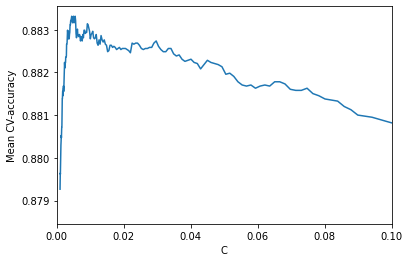

In [38]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy')
plt.xlim((0,.1))

In [36]:
optim_c = logit_searcher.C_[0]
print(optim_c)

0.005514205739240302


We see that the procedure selected C=0.005514205739240302.

Fit a model with the selected regularization parameter:

In [39]:
logit_model = LogisticRegression(C=optim_c, random_state=RANDOM_SEED, max_iter=10000)
logit_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.005514205739240302, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=2020, solver='warn', tol=0.0001,
                   verbose=0, warm_start=False)

* Accuracy on the training data:

In [40]:
logit_model.score(X_train_scaled, y_train)

0.8962195336670272

* Accuracy on the test data:

In [41]:
logit_model.score(X_test_scaled, y_test)

0.8471916775803702

* Accuracy on the lockbox data:

In [42]:
logit_model.score(X_lockbox_scaled, y_lockbox)

0.8558898919973357

* AUC of training data:

In [51]:
y_train_pred = logit_model.predict_proba(X_train_scaled)
roc_auc_score(y_train, y_train_pred[:,1])

0.899392832069842

* AUC on test data:

In [53]:
y_test_pred = logit_model.predict_proba(X_test_scaled)
roc_auc_score(y_test, y_test_pred[:,1])

0.7854016291679644

* AUC on lockbox data:

In [54]:
y_lockbox_pred = logit_model.predict_proba(X_lockbox_scaled)
roc_auc_score(y_lockbox, y_lockbox_pred[:,1])

0.7849248172411889

## Save CSV files

For easier processing in R, we will store the features, labels, and image ids in a common dataframe, which will be saved as CSV files.

In [11]:
num_features = X_train.shape[1]

In [47]:
train_df = pd.DataFrame(
    data=X_train,
    index=[os.path.basename(f) for f in img_names_train],
    columns=["x"+str(i) for i in range(num_features)]
)

train_df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x2038,x2039,x2040,x2041,x2042,x2043,x2044,x2045,x2046,x2047
ID_ee9b0a202.png,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.543290,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
ID_41eb170e8.png,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.448347,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
ID_e849bf0c7.png,0.0,0.0,0.040333,0.0,0.475496,0.0,0.0,0.204805,0.01947,0.0,...,0.0,0.347332,0.659752,0.0,0.015967,0.0,0.0,0.0,1.562007,0.0
ID_f308762e4.png,0.0,0.0,0.000000,0.0,0.182601,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.385913,0.0,0.000000,0.0,0.0,0.0,0.012844,0.0
ID_667d76de4.png,0.0,0.0,0.000000,0.0,0.023541,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.332624,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [48]:
train_splits_csv = 'train_splits_' + str(NUM_SUBJ_PER_SPLIT) + '.csv'
tmp_df = pd.read_csv(DATA_BASE_PATH + PNG_DIR + train_splits_csv)
tmp_df.set_index("filename", inplace=True)
tmp_df = tmp_df[['patient_ID', 'study_instance_ID', 'series_instance_ID', 'any',
                 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid',
                 'subdural', 'group', 'dataset']]
train_df = tmp_df.join(train_df)

# sanity checks
assert np.all(train_df.index.values == np.array([os.path.basename(f) for f in img_names_train]))
assert np.all(train_df["any"].values == y_train)

train_df.head()

,patient_ID,study_instance_ID,series_instance_ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,group,...,x2038,x2039,x2040,x2041,x2042,x2043,x2044,x2045,x2046,x2047
filename,,,,,,,,,,,,,,,,,,,,,
ID_ee9b0a202.png,ID_ea32a910,ID_1790cc3a1f,ID_e151adeb6a,0,0,0,0,0,0,90,...,0.0,0.000000,0.543290,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
ID_41eb170e8.png,ID_819de77c,ID_160028dd74,ID_906ccc12e2,0,0,0,0,0,0,48,...,0.0,0.000000,0.448347,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
ID_e849bf0c7.png,ID_010c18ba,ID_8da1ab563c,ID_e535911bd6,0,0,0,0,0,0,0,...,0.0,0.347332,0.659752,0.0,0.015967,0.0,0.0,0.0,1.562007,0.0
ID_f308762e4.png,ID_a95e54ce,ID_3a5287d677,ID_7572b6e358,0,0,0,0,0,0,48,...,0.0,0.000000,0.385913,0.0,0.000000,0.0,0.0,0.0,0.012844,0.0
ID_667d76de4.png,ID_e3ac70cb,ID_9375ebec9a,ID_0319db3904,0,0,0,0,0,0,15,...,0.0,0.000000,0.332624,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


Save a CSV file for each data split (i.e., `group`)

In [56]:
for i in np.unique(train_df.group.values):
    split_df = train_df.loc[train_df.group == i, :]
    if DEBUG_MODE:
        print(split_df.shape)
    split_df.to_csv(SAVE_DIR + "train_{}.csv".format(i))

(1865, 2059)
(2224, 2059)
(2168, 2059)
(1987, 2059)
(1829, 2059)
(2392, 2059)
(1868, 2059)
(2010, 2059)
(1986, 2059)
(1894, 2059)
(1886, 2059)
(2079, 2059)
(2016, 2059)
(2065, 2059)
(2043, 2059)
(1782, 2059)
(1991, 2059)
(1952, 2059)
(2126, 2059)
(2099, 2059)
(1966, 2059)
(2046, 2059)
(1661, 2059)
(2134, 2059)
(1917, 2059)
(1846, 2059)
(1870, 2059)
(1845, 2059)
(1909, 2059)
(1874, 2059)
(1960, 2059)
(1960, 2059)
(1992, 2059)
(1941, 2059)
(2037, 2059)
(1834, 2059)
(1760, 2059)
(1938, 2059)
(2065, 2059)
(2026, 2059)
(1929, 2059)
(2044, 2059)
(1948, 2059)
(1891, 2059)
(2153, 2059)
(1965, 2059)
(1794, 2059)
(2247, 2059)
(1885, 2059)
(1874, 2059)
(1896, 2059)
(1842, 2059)
(2150, 2059)
(1962, 2059)
(1972, 2059)
(1768, 2059)
(1915, 2059)
(2005, 2059)
(1899, 2059)
(1924, 2059)
(1738, 2059)
(1919, 2059)
(1944, 2059)
(2076, 2059)
(1801, 2059)
(1922, 2059)
(2027, 2059)
(2090, 2059)
(1807, 2059)
(2329, 2059)
(2099, 2059)
(2183, 2059)
(1868, 2059)
(2452, 2059)
(1907, 2059)
(2034, 2059)
(1982, 2059)

In [58]:
test_df = pd.DataFrame(
    data=X_test,
    index=[os.path.basename(f) for f in img_names_test],
    columns=["x"+str(i) for i in range(num_features)]
)

test_splits_csv = 'test_splits_' + str(NUM_SUBJ_PER_SPLIT) + '.csv'
tmp_df = pd.read_csv(DATA_BASE_PATH + PNG_DIR + test_splits_csv)
tmp_df.set_index("filename", inplace=True)
tmp_df = tmp_df[['patient_ID', 'study_instance_ID', 'series_instance_ID', 'any',
                 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid',
                 'subdural', 'group', 'dataset']]
test_df = tmp_df.join(test_df)

assert np.all(test_df.index.values == np.array([os.path.basename(f) for f in img_names_test]))
assert np.all(test_df["any"].values == y_test)

test_df

,patient_ID,study_instance_ID,series_instance_ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,group,...,x2038,x2039,x2040,x2041,x2042,x2043,x2044,x2045,x2046,x2047
filename,,,,,,,,,,,,,,,,,,,,,
ID_4166af295.png,ID_72a9811c,ID_4863457d29,ID_02da87fe38,0,0,0,0,0,0,37,...,0.0,0.009118,0.347835,0.0,0.000000,0.000000,0.0,0.0,0.029174,0.000000
ID_f428bb3e7.png,ID_63a3a20e,ID_0c081153a5,ID_0ed14b11a2,0,0,0,0,0,0,27,...,0.0,0.000000,0.443001,0.0,0.000000,0.000000,0.0,0.0,0.001659,0.000000
ID_8513fb5cc.png,ID_21f1a2b2,ID_e471623e54,ID_814abbd3e6,0,0,0,0,0,0,12,...,0.0,0.000000,0.295009,0.0,0.000000,0.000000,0.0,0.0,0.093052,0.000000
ID_3d2d45403.png,ID_efa577c6,ID_bce8bffc09,ID_74cac2aa47,1,0,0,0,0,1,59,...,0.0,0.085283,0.868931,0.0,0.000000,0.000000,0.0,0.0,1.091154,0.000000
ID_f66deaba0.png,ID_90336304,ID_33c9794544,ID_cdf2a654cf,0,0,0,0,0,0,19,...,0.0,0.501021,0.236501,0.0,0.001711,0.000000,0.0,0.0,1.017444,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_d0a1e36c4.png,ID_e19b9593,ID_75a973b040,ID_780ccc3380,0,0,0,0,0,0,6,...,0.0,0.040701,0.076559,0.0,0.000000,0.000000,0.0,0.0,0.317544,0.000000
ID_791b3c7a8.png,ID_41cac4db,ID_ab5c82c12e,ID_b09731925d,0,0,0,0,0,0,16,...,0.0,0.000000,0.393973,0.0,0.000000,0.000000,0.0,0.0,0.012179,0.000000
ID_5b6ef0304.png,ID_5e035492,ID_882103a5a0,ID_837bec96b7,0,0,0,0,0,0,78,...,0.0,0.000000,0.326547,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [61]:
for i, split_id in enumerate(np.unique(test_df.group.values)):
    split_df = test_df.loc[test_df.group == split_id, :]
    if DEBUG_MODE:
        print("{} - {}: {}".format(i, split_id, split_df.shape))
    split_df.to_csv(SAVE_DIR + "test_{}.csv".format(split_id))

0 - 0: (1946, 2059)
1 - 1: (2284, 2059)
2 - 2: (2080, 2059)
3 - 3: (2014, 2059)
4 - 4: (1934, 2059)
5 - 5: (1958, 2059)
6 - 6: (1905, 2059)
7 - 7: (2137, 2059)
8 - 8: (2006, 2059)
9 - 9: (1937, 2059)
10 - 10: (1889, 2059)
11 - 11: (1798, 2059)
12 - 12: (1969, 2059)
13 - 13: (2067, 2059)
14 - 14: (2221, 2059)
15 - 15: (1875, 2059)
16 - 16: (2031, 2059)
17 - 17: (2058, 2059)
18 - 18: (1842, 2059)
19 - 19: (1817, 2059)
20 - 20: (2066, 2059)
21 - 21: (2003, 2059)
22 - 22: (1847, 2059)
23 - 23: (1932, 2059)
24 - 24: (2029, 2059)
25 - 25: (1765, 2059)
26 - 26: (1736, 2059)
27 - 27: (1874, 2059)
28 - 28: (1989, 2059)
29 - 29: (1966, 2059)
30 - 30: (1913, 2059)
31 - 31: (2219, 2059)
32 - 32: (1868, 2059)
33 - 33: (2007, 2059)
34 - 34: (2204, 2059)
35 - 35: (2118, 2059)
36 - 36: (1924, 2059)
37 - 37: (2199, 2059)
38 - 38: (2305, 2059)
39 - 39: (2018, 2059)
40 - 40: (1885, 2059)
41 - 41: (1789, 2059)
42 - 42: (2471, 2059)
43 - 43: (2295, 2059)
44 - 44: (1939, 2059)
45 - 45: (1866, 2059)
46 - 46:

In [12]:
lockbox_df = pd.DataFrame(
    data=X_lockbox,
    index=[os.path.basename(f) for f in img_names_lockbox],
    columns=["x"+str(i) for i in range(num_features)]
)

lockbox_splits_csv = 'lockbox_splits_' + str(NUM_SUBJ_PER_SPLIT) + '.csv'
tmp_df = pd.read_csv(DATA_BASE_PATH + PNG_DIR + lockbox_splits_csv)
tmp_df.set_index("filename", inplace=True)
tmp_df = tmp_df[['patient_ID', 'study_instance_ID', 'series_instance_ID', 'any',
                 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid',
                 'subdural', 'group', 'dataset']]
lockbox_df = tmp_df.join(lockbox_df)

assert np.all(lockbox_df.index.values == np.array([os.path.basename(f) for f in img_names_lockbox]))
assert np.all(lockbox_df["any"].values == y_lockbox)

lockbox_df

,patient_ID,study_instance_ID,series_instance_ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,group,...,x2038,x2039,x2040,x2041,x2042,x2043,x2044,x2045,x2046,x2047
filename,,,,,,,,,,,,,,,,,,,,,
ID_9905e72aa.png,ID_6b6db689,ID_59997b389c,ID_07e6ba26b7,0,0,0,0,0,0,154,...,0.0,0.083733,0.268626,0.0,0.000489,0.0,0.0,0.0,0.230253,0.0
ID_cb6cbd668.png,ID_8cccd24b,ID_65aec600cf,ID_693d27318e,0,0,0,0,0,0,99,...,0.0,0.066508,0.466799,0.0,0.000000,0.0,0.0,0.0,0.667561,0.0
ID_11cb7b39e.png,ID_29b3dc58,ID_13dd543fb6,ID_f2ec368751,0,0,0,0,0,0,27,...,0.0,0.235219,0.543344,0.0,0.003986,0.0,0.0,0.0,0.568465,0.0
ID_aba36063c.png,ID_5ea5dd51,ID_61431aef67,ID_9a73bc2cfd,1,0,0,1,0,0,38,...,0.0,0.161716,0.517626,0.0,0.000000,0.0,0.0,0.0,0.310524,0.0
ID_16fcb6d14.png,ID_661994bf,ID_1c6c9c78c8,ID_9dc5f977ac,0,0,0,0,0,0,49,...,0.0,0.004976,0.131847,0.0,0.000000,0.0,0.0,0.0,0.168992,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_689339656.png,ID_bda8996b,ID_cd5a5322ca,ID_8d640abdb3,0,0,0,0,0,0,124,...,0.0,0.011921,0.099976,0.0,0.000000,0.0,0.0,0.0,0.195990,0.0
ID_8b1e96d9f.png,ID_8facb72b,ID_3d3c4925ad,ID_23a8ecf56e,0,0,0,0,0,0,172,...,0.0,0.000000,0.306544,0.0,0.000000,0.0,0.0,0.0,0.275055,0.0
ID_5c685fee9.png,ID_12e40fcb,ID_d9289716fa,ID_b32d2017d3,0,0,0,0,0,0,107,...,0.0,0.000000,0.248127,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [13]:
lockbox_df.to_csv(SAVE_DIR + "lockbox.csv")

Also save a smaller lockbox dataset:

In [14]:
NUM = 100_000
random.seed(RANDOM_SEED)
selection = random.sample(range(lockbox_df.shape[0]), NUM)
lockbox_small = lockbox_df.iloc[selection, :]
lockbox_small

,patient_ID,study_instance_ID,series_instance_ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,group,...,x2038,x2039,x2040,x2041,x2042,x2043,x2044,x2045,x2046,x2047
filename,,,,,,,,,,,,,,,,,,,,,
ID_2207dfcee.png,ID_a6acd683,ID_99d7b5a014,ID_e76ec0e5ad,0,0,0,0,0,0,153,...,0.0,0.000000,0.272080,0.000000,0.0,0.0,0.0,0.0,0.034274,0.0
ID_ef12c5f05.png,ID_cbdb1ce3,ID_8ae06d7228,ID_d81bbf8bf0,0,0,0,0,0,0,3,...,0.0,0.143045,0.127068,0.000000,0.0,0.0,0.0,0.0,0.576096,0.0
ID_fdbf03ecb.png,ID_c65d55c5,ID_c96695a840,ID_4842e96efe,0,0,0,0,0,0,5,...,0.0,0.038988,0.200112,0.001721,0.0,0.0,0.0,0.0,0.717783,0.0
ID_874d35e7a.png,ID_8963803b,ID_3eccfac1c1,ID_460d9592b1,0,0,0,0,0,0,119,...,0.0,0.042526,0.164795,0.000000,0.0,0.0,0.0,0.0,0.052238,0.0
ID_5979913ff.png,ID_2a359e53,ID_7e37ae1012,ID_3c49f68a78,0,0,0,0,0,0,107,...,0.0,0.218594,0.280462,0.000000,0.0,0.0,0.0,0.0,0.147246,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_456ad4225.png,ID_98f31fae,ID_7d2cae80c2,ID_8ca7d6502e,0,0,0,0,0,0,109,...,0.0,0.000000,0.559203,0.000000,0.0,0.0,0.0,0.0,0.013040,0.0
ID_37a048333.png,ID_65eacd81,ID_cc029c22cd,ID_c7a2130286,0,0,0,0,0,0,23,...,0.0,0.000000,0.311037,0.000000,0.0,0.0,0.0,0.0,0.352713,0.0
ID_e0cf229df.png,ID_74e102b8,ID_0c22607688,ID_3bfc85e84f,0,0,0,0,0,0,24,...,0.0,0.000000,0.358246,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [15]:
lockbox_small.to_csv(SAVE_DIR + "lockbox_small.csv")

In [16]:
lockbox_small['any'].sum() / NUM

0.14512